<a href="https://www.kaggle.com/code/scottfredschmidt/predicthouseprices?scriptVersionId=95640603" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Predict House Prices
Data has 79 explanatory variables describing aspects of residential homes in Ames, Iowa. Prediction modeling resulted in the following starting with the best:
* Decision tree r-squared is 0.9576 
* Gradient booster classification 0.899 with a deviation of 0.031. 
* Random forest  0.8905. 
* Linear regression 0.8002 result 
* Support vector machine delivered bad results. 

# Datasets
* Train.csv: This is the most important dataset that will be split to find patterns and predictions. 
*  Test.Csv: A final dollar price prediction will be made for all of the 1460 homes on the test data.  

# Train Data
The original dataset with no adjustments will be shown below. The data is in the shape of rows 1459 and 80 columns.  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from statistics import mean
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.datasets import make_classification
from sklearn import ensemble
import sklearn.metrics as metrics
import time
 
train=r'/kaggle/input/house-prices-advanced-regression-techniques/train.csv' 
test=r'/kaggle/input/house-prices-advanced-regression-techniques/test.csv'

data=pd.read_csv(train)  #(1459, 80) 
testDF=pd.read_csv(test)
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [3]:
#Check Duplicates:
dupstr = data.duplicated()
print('Total no of duplicate values in Training Dataset = %d' % (dupstr.sum()))
data[dupstr]

Total no of duplicate values in Training Dataset = 0


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


# Encode Categorical Variables
Change valuable columns SaleCondition, Street, and Fence into numerical values. 

In [4]:
data['Condition1'].unique()

array(['Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA',
       'RRNe'], dtype=object)

In [5]:
data['Condition2'].unique()

array(['Norm', 'Artery', 'RRNn', 'Feedr', 'PosN', 'PosA', 'RRAn', 'RRAe'],
      dtype=object)

In [6]:
data['BsmtCond'].unique()

array(['TA', 'Gd', nan, 'Fa', 'Po'], dtype=object)

#### Central Air

In [7]:
data['CentralAir'].unique()

array(['Y', 'N'], dtype=object)

In [8]:
data['CentralAir'] = data['CentralAir'].replace({'Y':0, 'N':1})

In [9]:
data['HouseStyle'].unique()

array(['2Story', '1Story', '1.5Fin', '1.5Unf', 'SFoyer', 'SLvl', '2.5Unf',
       '2.5Fin'], dtype=object)

#### SaleCondition

In [10]:
data['SaleCondition']=data['SaleCondition'].astype('str')
data['SaleCondition'].value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

In [11]:
data['SaleCondition']=data['SaleCondition'].apply(lambda x:5 if x == 'Normal' else 0)

#### Street

In [12]:
data['Street']=data['Street'].astype('str')
data['Street'].value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [13]:
data['Street']=data['Street'].fillna(0).apply(lambda x:0 if x =='Grvl' else 1)

#### Fence

In [14]:
data['Fence'].value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [15]:
data['Fence']=data['Fence'].fillna(0).apply(lambda x:0 if x == 0 else 1)
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,1,NaN,Reg,Lvl,AllPub,...,0,NaN,0,NaN,0,2,2008,WD,5,208500
1,2,20,RL,80.0,9600,1,NaN,Reg,Lvl,AllPub,...,0,NaN,0,NaN,0,5,2007,WD,5,181500
2,3,60,RL,68.0,11250,1,NaN,IR1,Lvl,AllPub,...,0,NaN,0,NaN,0,9,2008,WD,5,223500
3,4,70,RL,60.0,9550,1,NaN,IR1,Lvl,AllPub,...,0,NaN,0,NaN,0,2,2006,WD,0,140000
4,5,60,RL,84.0,14260,1,NaN,IR1,Lvl,AllPub,...,0,NaN,0,NaN,0,12,2008,WD,5,250000


# Numeric DataFrame
For now, we can analyze data by only having the number variables and not categorical values. Later on, we can encode categorical values to numeric values and see if there are any categorical values that may have high importance. 

In [16]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = data.select_dtypes(include=numerics)
df.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,SalePrice
0,1,60,65.0,8450,1,7,5,2003,2003,196.0,...,0,0,0,0,0,0,2,2008,5,208500
1,2,20,80.0,9600,1,6,8,1976,1976,0.0,...,0,0,0,0,0,0,5,2007,5,181500
2,3,60,68.0,11250,1,7,5,2001,2002,162.0,...,0,0,0,0,0,0,9,2008,5,223500
3,4,70,60.0,9550,1,7,5,1915,1970,0.0,...,272,0,0,0,0,0,2,2006,0,140000
4,5,60,84.0,14260,1,8,5,2000,2000,350.0,...,0,0,0,0,0,0,12,2008,5,250000


# Find Missing Values
First, missing data needs to be checked. Too many missing data points will get a column removed. An initial DataFrame with numeric values is analyzed. Some categorical values will be assigned a numeric value to analyze for better results. Deleting rows would be a bad idea since we need all rows to predict every house price. Therefore, any column with lots of missing data will be removed. If a column has high feature importance, filling in the missing data with the mean can be considered. Since a prediction is needed for every house price, one cannot simply remove rows of data.

In [17]:
#search for columns with missing values:
def findNA():
    print("Missing data by column as a percent:")
    findNA=df.isnull().sum().sort_values(ascending=False)/len(data)
    print(findNA.head(4))
findNA() 

Missing data by column as a percent:
LotFrontage    0.177397
GarageYrBlt    0.055479
MasVnrArea     0.005479
Id             0.000000
dtype: float64


# Fix Missing Values

In [18]:
number=100 #remove col with  or more missing values
df = df[df.isnull().sum(axis=1) <= number] 
df= df.fillna(df.mean())
df.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,SalePrice
0,1,60,65.0,8450,1,7,5,2003,2003,196.0,...,0,0,0,0,0,0,2,2008,5,208500
1,2,20,80.0,9600,1,6,8,1976,1976,0.0,...,0,0,0,0,0,0,5,2007,5,181500
2,3,60,68.0,11250,1,7,5,2001,2002,162.0,...,0,0,0,0,0,0,9,2008,5,223500
3,4,70,60.0,9550,1,7,5,1915,1970,0.0,...,272,0,0,0,0,0,2,2006,0,140000
4,5,60,84.0,14260,1,8,5,2000,2000,350.0,...,0,0,0,0,0,0,12,2008,5,250000


# Feature Engineering
For now, only numeric categorical values will be analyzed. Certain columns must be combined into one. For example, total square feet is a new column combined from three other columns. Since every house needs a dollar prediction price, one must not delete any rows. Therefore, any missing data will be filled in the mean. 

In [19]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'].drop(columns=['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'])
df.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,SalePrice,TotalSF
0,1,60,65.0,8450,1,7,5,2003,2003,196.0,...,0,0,0,0,0,2,2008,5,208500,2566
1,2,20,80.0,9600,1,6,8,1976,1976,0.0,...,0,0,0,0,0,5,2007,5,181500,2524
2,3,60,68.0,11250,1,7,5,2001,2002,162.0,...,0,0,0,0,0,9,2008,5,223500,2706
3,4,70,60.0,9550,1,7,5,1915,1970,0.0,...,0,0,0,0,0,2,2006,0,140000,2473
4,5,60,84.0,14260,1,8,5,2000,2000,350.0,...,0,0,0,0,0,12,2008,5,250000,3343


# Split Data
Split the data set into training data and test data. SalesPrice will always be Y since it is the independent variable which is what we are analyzing. 

In [20]:
X=df.drop('SalePrice', axis=1)
y=df['SalePrice']

# Heatmap
Using a visual heatmap can display all correlations between features and detect multicollinearity. The top ten correlations to SalesPrice will be shown below.

AxesSubplot(0.125,0.125;0.62x0.755)
Top ten correlations to sales price are: 
SalePrice       1.000000
OverallQual     0.790982
TotalSF         0.782260
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
Name: SalePrice, dtype: float64


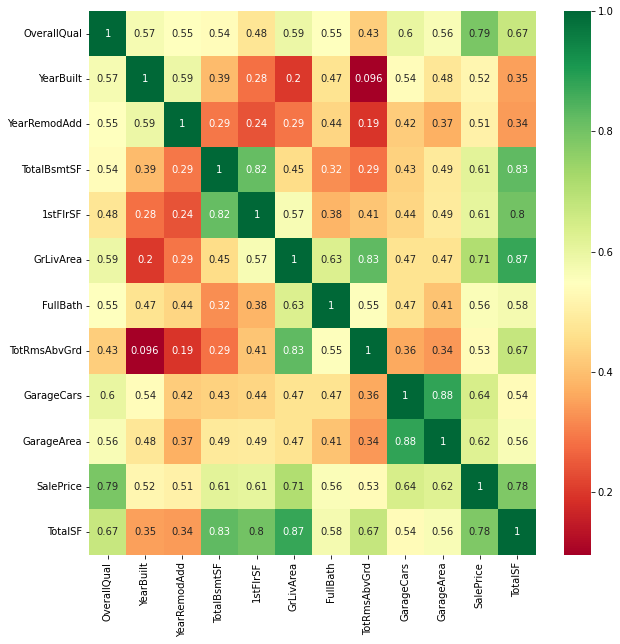

In [21]:
def printHeat():
    corr = df.corr()
    #print(corr)
    highly_corr_features = corr.index[abs(corr["SalePrice"])>0.5]
    plt.figure(figsize=(10,10))
    heat = sns.heatmap(df[highly_corr_features].corr(),annot=True,cmap="RdYlGn")
    top10=corr["SalePrice"].sort_values(ascending=False).head(10)
    print(heat)
    print("Top ten correlations to sales price are: ")
    print(top10) # top ten correlations
printHeat() 

## Correlations and Multicollinearity
No major multicollinearity was detected other than first floor and basement floor with a .82 correlation. The square feet features were all combined into total square feet of the entire house so the basement feature no longer exists anyway.

In [22]:
def printHighCorr(df, features, threshold=0.8):
    print("Highly correlated variables above: ", threshold)
    corr_df = df[features].corr() # get correlations
    correlated_features = np.where(np.abs(corr_df) > threshold) # select ones above the abs threshold
    correlated_features = [(corr_df.iloc[x,y], x, y) for x, y in zip(*correlated_features) if x != y and x < y] # avoid duplication
    s_corr_list = sorted(correlated_features, key=lambda x: -abs(x[0])) # sort by correlation value
    correlation_df={}
    if s_corr_list == []:
        print("There are no highly correlated features with correlation above", threshold)
    else:
        for v, i, j in s_corr_list:
            correlation_df[corr_df.index[i] +" and "+ corr_df.columns[j]]= v
        correlation_df=pd.DataFrame(correlation_df,index=['Correlation'])
    return  correlation_df.T.sort_values(by='Correlation',ascending=False)

printHighCorr(data,data.columns).style.set_properties(**{'background-color': 'black','color': 'white'})

Highly correlated variables above:  0.8


,Correlation
GarageCars and GarageArea,0.882475
YearBuilt and GarageYrBlt,0.825667
GrLivArea and TotRmsAbvGrd,0.825489
TotalBsmtSF and 1stFlrSF,0.819530


##  Scatterplot Data
The most important features that were found with the highest correlation to house sales price which were the following: 'OverallQual','TotalBsmtSF','MSSubClass', 'LotArea'. This helps visually see the extent of correlations between the quantities and variables.

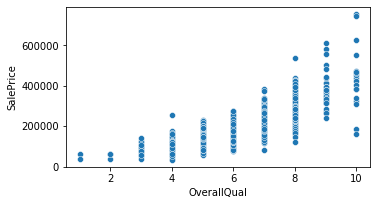

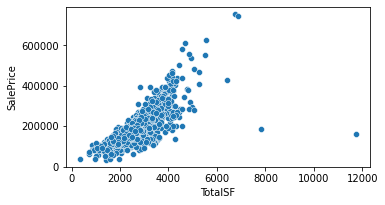

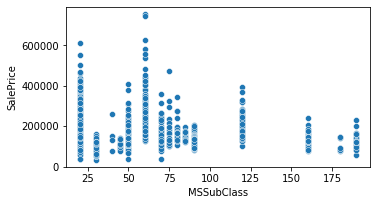

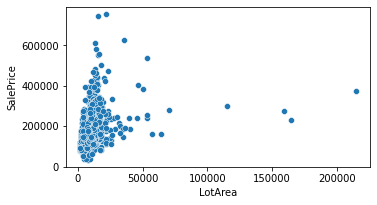

In [23]:
def pltFigure():
    names=['OverallQual','TotalSF','MSSubClass', 'LotArea']
    for name in names:
        fig = plt.figure(figsize=(12,10))
        plt.subplot(321)
        sns.scatterplot(data=df, x=name, y="SalePrice")
        plt.show()
pltFigure()

## Split Data 
Split the data set into training data and test data

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

# Gradient Boost
* max_depth of 3 provides the highest r-squared with the least amount of error
* n_estimators of 500 provides the highest r-squared with the least amount of error
* The best min_samples_split is 2

Some of the full reports are as follows: <br>
2  max_depth:
Gradient boosting regression r2:  0.7792
The mean squared error (MSE) on test set: 1588734714.0506

3  max_depth:
Gradient boosting regression r2:  0.7904
The mean squared error (MSE) on test set: 1508495269.5377

4  max_depth:
Gradient boosting regression r2:  0.7728
The mean squared error (MSE) on test set: 1634504123.5357

5  max_depth:
Gradient boosting regression r2:  0.7521
The mean squared error (MSE) on test set: 1784152419.9921

N_ESTIMATORS:
100  n_estimators:
Gradient boosting regression r2:  0.6029
The mean squared error (MSE) on test set: 2857489055.9958

200  n_estimators:
Gradient boosting regression r2:  0.7365
The mean squared error (MSE) on test set: 1895949920.8003

300  n_estimators:
Gradient boosting regression r2:  0.7735
The mean squared error (MSE) on test set: 1629727173.5473

400  n_estimators:
Gradient boosting regression r2:  0.7803
The mean squared error (MSE) on test set: 1580588583.2762

500  n_estimators:
Gradient boosting regression r2:  0.7809
The mean squared error (MSE) on test set: 1576535527.4767

In [25]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor

def gbDepth():
    depthList=[2, 3, 4, 5, 7]
    print("staring max_depth calculations:")
    for d in depthList:
        params = {
         "n_estimators": 10, "max_depth": d, 
            "min_samples_split": 5, "learning_rate": 0.01,
        }

        #Fit and Predict:
        reg = ensemble.GradientBoostingRegressor(**params)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        gbr_r2 = r2_score(y_test, y_pred).round(4) 
        mse = mean_squared_error(y_test, reg.predict(X_test))
        print(d, " max_depth || GB reg r2: ", gbr_r2, "|| MSE: {:.4f}".format(mse)) 

def gbN():
    nList=[2, 50, 100, 200, 300, 400, 500]
    print("starting GB n_estimators calculations:")
    for n in nList:
        params = {
         "n_estimators": n, "max_depth": 2, 
            "min_samples_split": 5, "learning_rate": 0.01,
        }

        #Fit and Predict:
        reg = ensemble.GradientBoostingRegressor(**params)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        gbr_r2 = r2_score(y_test, y_pred).round(4) 
        mse = mean_squared_error(y_test, reg.predict(X_test))
        print(n, "n_estimators || GB regression r2: ", gbr_r2, "|| MSE: {:.4f}".format(mse)) 

def gbSplit():
    sList=[2, 3, 5, 7]
    
    for s in sList:
        params = {
         "n_estimators": 500, "max_depth": 2,
            "min_samples_split": s, "learning_rate": 0.01,
        }

        #Fit and Predict:
        reg = ensemble.GradientBoostingRegressor(**params)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        gbr_r2 = r2_score(y_test, y_pred).round(4)
        mse = mean_squared_error(y_test, reg.predict(X_test)).round(4)
        print(s," min_samples_splits || R2 ", gbr_r2, " || MSE {:.4f}".format(mse))

#Turn on or off functions here:
#gbDepth()
#gbN()
#gbSplit()

Gradient boosting regression r2:  0.7816
The mean squared error (MSE) on test set: 1571810148.2495


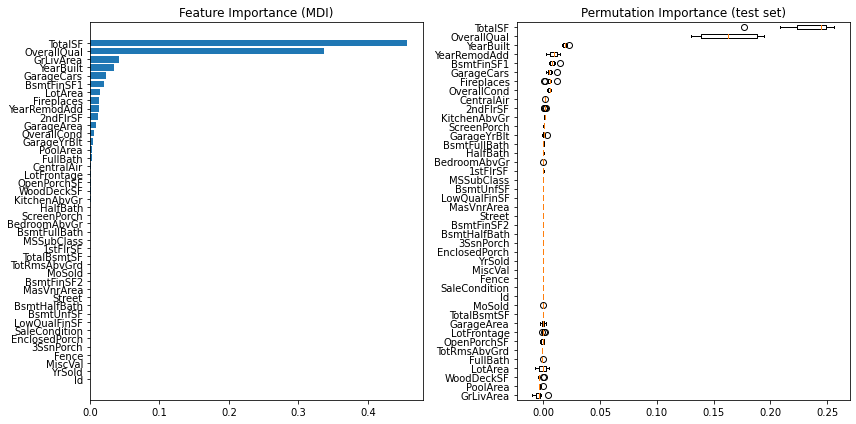

In [26]:
params = {
 "n_estimators": 500, "max_depth": 2, "min_samples_split": 2, "learning_rate": 0.01,
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
gbr_r2 = r2_score(y_test, y_pred).round(4) 
print("Gradient boosting regression r2: ", gbr_r2) 

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

#FEATURE IMPORTANCE:
cols=X.columns
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(cols)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(cols)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Linear Regression
R-squared and accuracy produced a 0.7979 performance result:
* The linear regression cross validated is 0.7785.
* Both ridge and lasso regression r-squared result is 0.7785.

Linear regression r2 score:  0.6106
Linear Accuracy:  0.6106
0.7873  linear regression cross validate mean


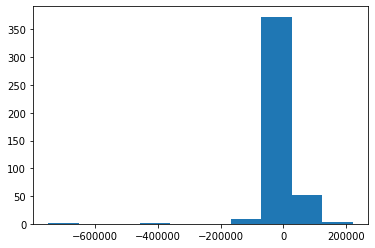

In [27]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

#Fit and predict:
lrModel = LinearRegression()
lrModel.fit(X_train, y_train)
lrPredict = lrModel.predict(X_test)

# plt.scatter(y_test, predictions)
plt.hist(y_test - lrPredict)

#Linear Metrics:
#auc = round( metrics.roc_auc_score(y_test, lrPredict), 4 )
#print("AUC for linear regression is: ", auc)

r2 = r2_score(y_test, lrPredict).round(4) 
print("Linear regression r2 score: ", r2)

#CROSS VALIDATE TEST RESULTS:
lr_score = lrModel.score(X_test, y_test).round(4)  # train test 
print("Linear Accuracy: ", lr_score)
lr_cv = cross_validate(lrModel, X, y, cv = 5, scoring= 'r2')
lr_cvMean=lr_cv['test_score'].mean().round(4)
print(lr_cvMean, " linear regression cross validate mean")

def linearReports():
    print(model.coef_)    
    print(model.intercept_)
    print(classification_report(y_test_data, lrPredict))
    print(confusion_matrix(y_test_data, lrPredict))
    metrics.mean_absolute_error(y_test, lrPredict)
    np.sqrt(metrics.mean_squared_error(y_test, lrPredict))

# Random Forest Prediction:
R-squared for random forest is 0.8905. The results used an n_estimator of 400 which provides the lowest mean absolute error (MAE). checkMAE function will check which number for n_estimators value produces the least amount of MAE error.

In [28]:
from sklearn.ensemble import RandomForestRegressor

#Check for Error and find Best n_estimators:
def checkMAE():
    dMAE={} #dictionary of n_estimators as key and MAE as value:
    for n in range(100, 1401, 100):
        forest = RandomForestRegressor(n_estimators=n, random_state = 0)
        forest.fit(X_train, y_train)
        y_pred = forest.predict(X_test)
        MAE=metrics.mean_absolute_error(y_test, y_pred).round(2)
        dMAE[n]=MAE
        #print("n_estimates: ", n,  '  Mean Absolute Error:', MAE)

    dMAE=sorted(((v, k) for k, v in dMAE.items()), reverse=False)
    #print(dMAE) #[(18573.45, 400), (18632.04, 200), (18636.62, 500), (18644.81, 300), (18651.96, 600),
#checkMAE() #turn function on or off by uncommenting

#Fit and predict:
num=10
forest = RandomForestRegressor(n_estimators=num, random_state = 0)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

#Print Metrics:
forest_r2 = r2_score(y_test, y_pred).round(4)  
print("Random forest r2: ", forest_r2)

#forest_auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
#print("Random forest AUC: ", forest_auc) 

Random forest r2:  0.7638


# K-Nearest Neighbors (KNN)
First, we must select the optimal K value with the least amount of error. Because the large amount of data, the KNN model runs very slow which is a big issue for KNN. If you do run the KNN model, after some time, the final metrics show the following results:

In [29]:
from sklearn.neighbors import KNeighborsClassifier

def knnError():
    print("Selecting an optimal K value:")
    error_rates = []
    for i in range(1, 10, 2): #Must be an odd number to break a tie
        new_model = KNeighborsClassifier(n_neighbors = i)
        new_model.fit(X_train, y_train)
        new_predictions = new_model.predict(X_test)
        error_rates.append(np.mean(new_predictions != y_test))
    plt.figure(figsize=(16,12))
    plt.plot(error_rates)

def knnModel():
    #Train the model and make predictions:
    knn = KNeighborsClassifier(n_neighbors =3) 
    knn.fit(X_train, y_train)
    knnPredict = knn.predict_proba(X_test)[::,1]

    #calculate AUC of model
    knn_auc = round( metrics.roc_auc_score(y_test, knnPredict), 4 ) 
    print("Knn AUC: ", knn_auc)

def knnReports():
    acc = metrics.accuracy_score(y_test_data, knnPredict)
    print(confusion_matrix(y_test, knnPredict))
    print(classification_report(y_test, knnPredict))
    print(confusion_matrix(y_test, knnPredict))

# Decision Tree
* The decision tree r-squared provides high results overall as a model. 
* The highest r-squared is by using max_depth = 3. However, this provides high error and bad score. 
* Using max_depth = 5 and max_leaf_nodes =25 provides high r-squared and low error.
* The best max_depth dictionary with error as a value is 10: <br>
{2: 36106.9895, 3: 31746.944, 5: 29228.6968, 7: 30077.7522, 9: 29128.2362, 10: 29095.3825, 12: 29095.3825}

In [30]:
from sklearn.tree import DecisionTreeRegressor

#FIND best_tree_size LEAF NODES:
def calcLeaf():
    candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]
    maeDic={} #dictionary  key=leaf  mae=value
    for leaf in candidate_max_leaf_nodes:
        model = DecisionTreeRegressor(max_leaf_nodes=leaf, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        maeDic[leaf]=mae
    print(maeDic)
    best_tree_size = sorted(maeDic, key=lambda x : maeDic[x])[0]
    print(best_tree_size)
    
def calcDepth():
    max_depth_list = [2, 3, 5, 7, 9, 10, 12]
    maeDic={} #dictionary  key=depth  mae=value
    for d in max_depth_list:
        model = DecisionTreeRegressor(max_leaf_nodes=100, max_depth=d, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        maeDic[d]=mae
    print(maeDic)
    best_max_depth = sorted(maeDic, key=lambda x : maeDic[x])[0]
    print(best_max_depth, " best max_depth with least error.") #10
    
def automateTree():
    print("Decision Tree Automating:")
    start=time.time()
    candidate_max_leaf_nodes = [5, 50, 100, 250, 500]
    max_depth_list = [2, 3, 5, 7, 9, 11]
    
    #STORE DATA INTO LISTS FOR DATAFRAME LATER:
    aucList=[]
    maeList=[]
    maxDepthList=[]
    maxLeafNodesList=[]

    for d in max_depth_list:
        for leaf in candidate_max_leaf_nodes:
            model = DecisionTreeRegressor(max_leaf_nodes=leaf, max_depth=d, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred).round(4)
            treeR2 = r2_score(y_test, y_pred).round(4)
            
            aucList.append(treeR2)
            maeList.append(mae)
            maxDepthList.append(d)
            maxLeafNodesList.append(leaf)
           
    df = pd.DataFrame(list(zip(aucList, maeList, maxDepthList, maxLeafNodesList)),
                          columns=['AUC','MAE', 'MaxDepth', 'MaxLeafNodes'])
    
    df=df.sort_values(by=['MAE'], ascending=False)
    print("Done. ", round(time.time()-start,4), " seconds")
    return df
    
treeDF=automateTree()    
treeDF.head(50)

Decision Tree Automating:
Done.  0.3926  seconds


,AUC,MAE,MaxDepth,MaxLeafNodes
0,0.6036,36106.9895,2,5
2,0.6036,36106.9895,2,100
3,0.6036,36106.9895,2,250
4,0.6036,36106.9895,2,500
1,0.6036,36106.9895,2,50
10,0.6087,36011.4462,5,5
25,0.6087,36011.4462,11,5
20,0.6087,36011.4462,9,5
15,0.6087,36011.4462,7,5
5,0.6087,36011.4462,3,5


#### Decision tree make prediction
Input best_tree_size and best_depth from above functions. 
High accuracy does not equal high score. Best scores seem to take account error as well into account.

In [31]:
best_tree_size=100
best_depth=5

tree = DecisionTreeRegressor(max_leaf_nodes=best_tree_size, max_depth=best_depth, random_state=42)
tree.fit(X, y)
y_pred = tree.predict(X_test)

#AUC and r2 metric
tree_r2 = r2_score(y_test, y_pred).round(4)
print("Decision Tree r-squared is:", tree_r2)
#tree_auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
#print("AUC for decision tree is: ", tree_auc)

def printReports(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

Decision Tree r-squared is: 0.8595


# Support Vector Machine
SVM r_squared is 0.4196. With a large number of samples, SVM is extremely slow. In this model, SVM is slow and should consider not being used.

#### GridSearch Tune
The best SVM parameters is SVC(C=0.1, gamma=1)

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

def tuneSVM():
    # defining parameter range
    param_grid = {'C': [0.1, 1, 10, 100, 1000],
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'kernel': ['rbf']}

    grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

    # fitting the model for grid search
    grid.fit(X_train, y_train)

    # print best parameter after tuning
    print(grid.best_params_)

    # print how our model looks after hyper-parameter tuning
    print(grid.best_estimator_)

In [33]:
def runSVM():
    svm=SVC(C=0.1, gamma=1, kernel = 'linear')
    svm.fit(X_train, y_train)
    svmPedict = svm.predict(X_test)
    np.shape(svmPedict)
    np.shape(y_test)
    #y_class = np.argmax(y_pred, axis = 0)

    #calculate AUC of model
    svmAUC = round( metrics.roc_auc_score(y_test, svmPedict, multi_class='ovr'), 4 ) 
    print("SVC AUC is: ", svmAUC)

    svmR2 = r2_score(y_test, svmPedict).round(4) 
    print("SVM r2: ", svmR2) 

    svmMAE=metrics.mean_absolute_error(y_test, svmPedict)

# Feature Engineer Test Data 
First, we will display the test data. As we can see there is no SalesPrice prediction at the end. This is what we will be predicting. 

In [34]:
testDF.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Match Test Columns with Trained

In [35]:
features = list(X.columns.values)
testDF['TotalSF'] = testDF['TotalBsmtSF'] + testDF['1stFlrSF'] + testDF['2ndFlrSF'].drop(columns=['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'])
testDF['SaleCondition']=testDF['SaleCondition'].apply(lambda x:1 if x == 'Normal' else 0)
testDF['Fence']=testDF['Fence'].fillna(0).apply(lambda x:0 if x == 0 else 1)
testDF['Street']=testDF['Street'].fillna(0).apply(lambda x:0 if x =='Grvl' else 1)
testDF['CentralAir'] = testDF['CentralAir'].replace({'Y':0, 'N':1})
testDF=testDF[features]

#Fill Missing Values:
testDF= testDF.fillna(testDF.mean())
print(testDF.shape)
testDF.head()

(1459, 42)


,Id,MSSubClass,LotFrontage,LotArea,Street,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,TotalSF
0,1461,20,80.0,11622,1,5,6,1961,1961,0.0,...,0,0,120,0,1,0,6,2010,1,1778.0
1,1462,20,81.0,14267,1,6,6,1958,1958,108.0,...,0,0,0,0,0,12500,6,2010,1,2658.0
2,1463,60,74.0,13830,1,5,5,1997,1998,0.0,...,0,0,0,0,1,0,3,2010,1,2557.0
3,1464,60,78.0,9978,1,6,6,1998,1998,20.0,...,0,0,0,0,0,0,6,2010,1,2530.0
4,1465,120,43.0,5005,1,8,5,1992,1992,0.0,...,0,0,144,0,0,0,1,2010,1,2560.0


## Create Final Prediction

In [36]:
test_predictions = reg.predict(testDF).round(2)
output = pd.DataFrame({'Id': testDF['Id'], 'SalePrice': test_predictions}).sort_values(by='Id').reset_index(drop=True)
print(output.shape) #(1459, 2)
output.head()

(1459, 2)


,Id,SalePrice
0,1461,121994.81
1,1462,159307.82
2,1463,180017.71
3,1464,179675.56
4,1465,194200.98


In [37]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
